# Задание 2   
    Задание простого уровня Загрузите данные из файла non_linear.csv и сгенерируйте данные до степени degree = 8 включительно. Обучите модель sklearn.linear_model.Lasso и модель sklearn.linear_model.Ridge на полученных данных, используйте коэффициент регуляризации  α=0.8  для обеих моделей. Постройте два столбчатых графика, на которых отобразите величину коэффициентов для Ridge регрессии и Lasso регрессии в виде столбиков.
    

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv('non_linear.csv', sep=',')
data.head()

,x_train,y_train
0,0.138368,0.838812
1,0.157237,0.889313
2,0.188684,1.430040
3,0.685553,1.717309
4,0.874237,2.032588


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

def generate_degrees(source_data: list, degree: int):
    """Функция, которая принимает на вход одномерный массив, а возвращает n-мерный
    Для каждой степени от 1 до  degree возводим x в эту степень
    """
    return np.array([
          source_data**n for n in range(1, degree + 1)  
    ]).T

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7134369621139327, tolerance: 0.0024481555784964045
  positive)


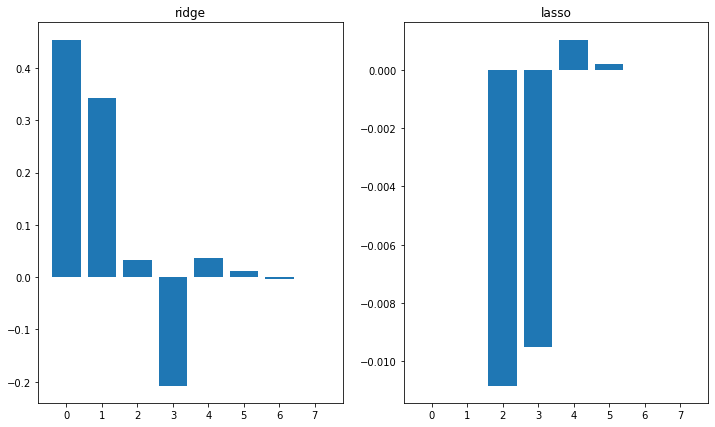

In [5]:
X = generate_degrees(data['x_train'], degree=8)
y = data.y_train.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)
model = Ridge(alpha=0.8).fit(X_train, y_train)
model2 = Lasso(alpha=0.8).fit(X_train, y_train)
fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(12, 7))
plt.subplot(121)
model_coef1 = model.coef_
model_coef2 = model2.coef_
plt.title('ridge')
plt.bar(range(8), model_coef1)
plt.subplot(122)
plt.title('lasso')
plt.bar(range(8), model_coef2)
plt.show()
    

Количество коэффициентов разное, при lasso регуляризации некоторые переменные из уравнения линейной регрессии исчезают как ненужные чтобы предотвратить переобучение

# Задание 4   
   Задание среднего уровня Примените градиентный спуск к задаче прогнозирования цен на недвижимость в Бостоне. Какого качества на валидации удалось достичь по r2-score? Сколько итераций понадобилось?

In [6]:
from sklearn.datasets import load_boston
from sklearn.linear_model import SGDRegressor
from scipy.spatial import distance
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

boston_dataset = load_boston()
X = boston_dataset.data
y = boston_dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [7]:
scaler = StandardScaler()

scaler_y = StandardScaler()

X_train_z, X_test_z = scaler.fit_transform(X_train), scaler.transform(X_test)

y_train_z, y_test_z = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel(), scaler_y.transform(y_test.reshape(-1,1)).ravel()

Итарации остановлены на шаге 186


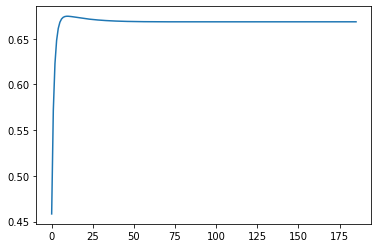

In [8]:
sgd_regressor = SGDRegressor(learning_rate='constant', eta0=0.0009, fit_intercept=True, random_state=42)
w_current, epsilon = np.random.random(13), 0.0001
weight_evolution, mse_evolution = [], [] 
for step in list(range(8000)):
    sgd_regressor = sgd_regressor.partial_fit(X_train_z, y_train_z)
    weight_evolution.append(distance.euclidean(w_current, sgd_regressor.coef_))
    if weight_evolution[-1]<epsilon:
        print("Итарации остановлены на шаге %d" % step); break
    mse_evolution.append(r2_score(y_test_z, sgd_regressor.predict(X_test_z)))
    w_current = sgd_regressor.coef_.copy()
plt.plot(range(step), mse_evolution)

186 шагов

In [9]:
print(f'Конечная r2 score {mse_evolution[-1]}')

Конечная r2 score 0.6684395970054713


# Урок 5. Домашняя работа   
   В реализацию функции gradient добавьте параметр  λ , чтобы получить регуляризованный градиентный спуск


In [30]:
def gradient(X, y, w, lam=0) -> np.array:
    # количество обучающих примеров в выборке
    n = X.shape[0]
    # считаем прогноз
    y_hat = X.dot(w.T)
    # вычисляем ошибку прогноза
    error = y - y_hat
    # дальше перемножение - умножаем каждую из координат на ошибку
    grad = (np.multiply(X, error).sum(axis=0)*(-1.0) + 2 * lam * w)*2.0 / n
    print((np.multiply(X, error).sum(axis=0)))
    return grad, error

In [11]:
def eval_w_next(X, y, eta, w_current, lam=0):
    # вычисляем градиент
    grad, error = gradient(X, y, w_current, lam)
    # делаем шаг градиентного спуска
    w_next = w_current - eta*grad
    # проверяем условие сходимости
    weight_evolution = distance.euclidean(w_current, w_next)
    return (w_next, weight_evolution, grad)

In [12]:
def gradient_descent(X: np.array, y: np.array, eta=0.01, epsilon=0.001, lam=0) -> np.array:
    m = X.shape[1] # количество фичей
    # инициализируем рандомом веса
    w = np.random.random(m).reshape(1, -1)
    w_next, weight_evolution, grad = eval_w_next(X, y, eta, w, lam)
    step = 0
    # повторяем до сходимости вектора весов
    while weight_evolution > epsilon:
        w = w_next
        w_next, weight_evolution, grad = eval_w_next(X, y, eta, w, lam)
        step += 1
        if step % 100 ==0:
            print("step %s |w-w_next|=%.5f, grad=%s" % (step, weight_evolution, grad))
    return w

In [31]:
# трансформируем плоский массив X в вектор-столбец
X = data['x_train'].values.reshape(-1, 1)
n = X.shape[0]
# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X = np.hstack([
    np.ones(n).reshape(-1,1),
    X
])
w = gradient_descent(X, data['y_train'].values.reshape(-1, 1), eta=0.008)

[-112.22923048 -558.10560418]
[ -80.76261927 -427.21888548]
[ -56.75789247 -327.30128638]
[ -38.44922781 -251.02431967]
[ -24.48866546 -192.79370344]
[ -13.84722552 -148.33898064]
[  -5.73942494 -114.40025053]
[  0.43434331 -88.48903176]
[  5.13179572 -68.70571451]
[  8.70233508 -53.60021053]
[ 11.41268176 -42.06557889]
[ 13.46643951 -33.25682391]
[ 15.01903137 -26.52890876]
[ 16.18910108 -21.38943739]
[ 17.06721651 -17.46253379]
[ 17.72251347 -14.4612688 ]
[ 18.20776741 -12.16661185]
[ 18.5632649  -10.41136348]
[18.81975898 -9.06789008]
[19.00072517 -8.03876112]
[19.12408363 -7.24960185]
[19.20351375 -6.64363748]
[19.2494577  -6.17752828]
[19.26988647 -5.81819037]
[19.27088465 -5.54036877]
[19.25709685 -5.32478475]
[19.23206841 -5.15672167]
[19.19850558 -5.02494537]
[19.15847404 -4.9208801 ]
[19.11355051 -4.83797943]
[19.06493846 -4.77124604]
[19.0135564  -4.71686511]
[18.96010537 -4.67192455]
[18.90512035 -4.63420134]
[18.84900959 -4.60199847]
[18.79208457 -4.57402048]
[18.73458295 -

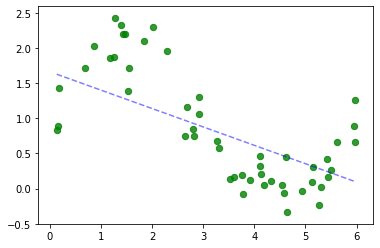

In [14]:
support = np.linspace(X.min(), X.max(), num=100)
# делаем предикт - считаем предсказания модели в каждой точке обучающей выборке в виде y=X*w
y_hat = np.hstack([
    np.ones(support.size).reshape(-1, 1),
    support.reshape(-1, 1)
]).dot(w.T)

# строим график
plt.plot(support, y_hat, 'b--', alpha=0.5, label='manifold')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')
plt.show()

In [15]:
# трансформируем плоский массив X в вектор-столбец
X = data['x_train'].values.reshape(-1, 1)
n = X.shape[0]
# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X = np.hstack([
    np.ones(n).reshape(-1,1),
    X
])
w = gradient_descent(X, data['y_train'].values.reshape(-1, 1), eta=0.008, lam = 1)

step 100 |w-w_next|=0.00362, grad=[[-0.44040315  0.10611658]]
step 200 |w-w_next|=0.00247, grad=[[-0.30005066  0.07229819]]
step 300 |w-w_next|=0.00168, grad=[[-0.20442723  0.04925741]]
step 400 |w-w_next|=0.00115, grad=[[-0.13927813  0.03355952]]


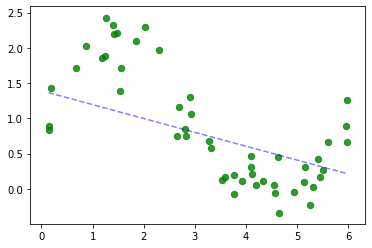

In [16]:
support = np.linspace(X.min(), X.max(), num=100)
# делаем предикт - считаем предсказания модели в каждой точке обучающей выборке в виде y=X*w
y_hat = np.hstack([
    np.ones(support.size).reshape(-1, 1),
    support.reshape(-1, 1)
]).dot(w.T)

# строим график
plt.plot(support, y_hat, 'b--', alpha=0.5, label='manifold')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')
plt.show()

In [27]:
def gradient(X, y, w, lam=0) -> np.array:
    # количество обучающих примеров в выборке
    n = X.shape[0]
    # считаем прогноз
    y_hat = X.dot(w.T)
    # вычисляем ошибку прогноза
    error = y - y_hat
    # дальше перемножение - умножаем каждую из координат на ошибку
    pointwise_errors = np.multiply(X, error) + 2*w*lam
    print(pointwise_errors.sum(axis=0))
    grad = pointwise_errors.sum(axis=0)*(-1.0)*2.0 / n 
    return grad, error

In [28]:
# трансформируем плоский массив X в вектор-столбец
X = data['x_train'].values.reshape(-1, 1)
n = X.shape[0]
# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X = np.hstack([
    np.ones(n).reshape(-1,1),
    X
])
w = gradient_descent(X, data['y_train'].values.reshape(-1, 1), eta=0.8, lam = 0.5)

[  -5.31815459 -177.07187572]
[ 936.06096528 3531.26788232]
[-17837.455933   -74835.15146148]
[ 380013.69197386 1575286.53460399]
[ -7994788.0400309  -33184023.07387409]
[1.68423665e+08 6.98979329e+08]
[-3.54760714e+09 -1.47232379e+10]
[7.47265325e+10 3.10128676e+11]
[-1.57403140e+12 -6.53251724e+12]
[3.31552293e+13 1.37600242e+14]
[-6.98378193e+14 -2.89839675e+15]
[1.47105634e+16 6.10515184e+16]
[-3.09861729e+17 -1.28598264e+18]
[6.52689424e+18 2.70878004e+19]
[-1.37481800e+20 -5.70574522e+20]
[2.89590190e+21 1.20185206e+22]
[-6.09989671e+22 -2.53156828e+23]
[1.28487570e+24 5.33246828e+24]
[-2.7064484e+25 -1.1232254e+26]
[5.70083389e+26 2.36594994e+27]
[-1.20081754e+28 -4.98361158e+28]
[2.52938918e+29 1.04974260e+30]
[-5.32787825e+30 -2.21116655e+31]
[1.12225856e+32 4.65757752e+32]
[-2.36391340e+33 -9.81067134e+33]
[4.97932184e+34 2.06650929e+35]
[-1.04883901e+36 -4.35287301e+36]
[2.20926325e+37 9.16884504e+37]
[-4.65356842e+38 -1.93131569e+39]
[9.80222661e+39 4.06810265e+40]
[-2.0647

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


ValueError: array must not contain infs or NaNs

In [19]:
data = pd.read_csv('non_linear.csv', sep=',')

data = data[(data.x_train > 1) & (data.x_train < 5)].copy()

In [32]:
# трансформируем плоский массив X в вектор-столбец
X = data['x_train'].values.reshape(-1, 1)
n = X.shape[0]
# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X = np.hstack([
    np.ones(n).reshape(-1,1),
    X
])
w = gradient_descent(X, data['y_train'].values.reshape(-1, 1), eta=0.008, lam = 0.01)

[ -14.25452013 -108.10282542]
[ -8.27893981 -83.14717466]
[ -3.72574107 -64.09516493]
[ -0.25829746 -49.54973355]
[  2.38035632 -38.44442617]
[  4.38637582 -29.96515987]
[  5.90949724 -23.49050061]
[  7.0640223  -18.54607381]
[  7.93720369 -14.76976339]
[  8.59564606 -11.88514632]
[ 9.09019229 -9.68121379]
[ 9.45965348 -7.9968912 ]
[ 9.73365614 -6.70922148]
[ 9.93481576 -5.72434478]
[10.08039588 -4.9706127 ]
[10.18357462 -4.39333209]
[10.25441147 -3.95075265]
[10.30058534 -3.6110041 ]
[10.32795785 -3.34975806]
[10.34100343 -3.14844334]
[10.34313756 -2.99288353]
[10.3369674  -2.87225697]
[10.32448306 -2.77830286]
[10.3072036 -2.7047153]
[10.28628853 -2.64668059]
[10.2626229  -2.60052419]
[10.23688223 -2.56344106]
[10.2095821  -2.53328999]
[10.181116   -2.50843641]
[10.15178424 -2.48763258]
[10.12181597 -2.469926  ]
[10.09138603 -2.45458956]
[10.06062782 -2.44106819]
[10.0296431  -2.42893816]
[ 9.99850945 -2.41787599]
[ 9.96728604 -2.40763476]
[ 9.93601794 -2.39802592]
[ 9.90473948 -2.38

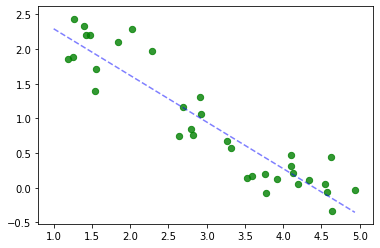

In [22]:
support = np.linspace(X.min(), X.max(), num=100)
# делаем предикт - считаем предсказания модели в каждой точке обучающей выборке в виде y=X*w
y_hat = np.hstack([
    np.ones(support.size).reshape(-1, 1),
    support.reshape(-1, 1)
]).dot(w.T)

# строим график
plt.plot(support, y_hat, 'b--', alpha=0.5, label='manifold')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')
plt.show()